In [1]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torch.utils.data import DataLoader
from torchmeta.modules import MetaModule
import sys
import os
    
from autoint.session import Session
import autoint.autograd_modules as autoint


In [2]:
import numpy as np
from prettytable import PrettyTable
from scipy.integrate import quad
import math 
def cv_monte_carlo_integration(f, cv_fn, g_integral, l, u, n_samples, device, chunk_size=1000):
    """
    Monte Carlo integration with control variates.

    Args:
        f (function): The target function to integrate.
        g (function): Control variate function, closely resembling f.
        g_integral (float): Analytical integral of the control variate g over the domain.
        domain (tuple): The integration domain (start, end).
        n_samples (int): Number of samples.

    Returns:
        float: Estimated integral of f.
    """
    start, end = l, u
    # Generate random samples in the domain
    samples = torch.rand(n_samples) * (end - start) + start
    # Compute the function values
    f_values = f(samples)
    g_values_list = []
    with torch.no_grad():
        # Split the 'samples' tensor into smaller chunks
        for i in range(0, n_samples, chunk_size):
            batch = samples[i : i + chunk_size]
            # Pass shape [chunk_size, 1] to the network
            batch = batch.view(-1, 1).to(device)
            g_output = cv_fn.compute_graph_fast2({'x_coords': batch, 'params': None})
            g_values_list.append(g_output.detach().cpu())
    # with torch.no_grad():
    #     g_values =  cv_fn.compute_graph_fast2({'x_coords': samples.to(device).view(-1,1), 'params': None})
    g_values = torch.cat(g_values_list, dim=0) 
    g_values= g_values.detach().cpu()
    residual = f_values - g_values.squeeze()
    # Monte Carlo estimate with control variates
    integral_estimate = g_integral + (end - start) * torch.mean(residual)
    return integral_estimate, torch.std(residual) * (end-start) / math.sqrt(n_samples)

def display_integration_results(func, domain, cv_fn, g_integral, sample_sizes, device):
    # Numerical quadrature integration
    quad_result, _ = quad(integral_xcosx_fn_numpy, domain[0], domain[1])

    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Sample Size", "Integration Result (mean ± std.dev)"]

    # Compute and add results for different sample sizes
    for n_samples in sample_sizes:
        mc_mean, mc_std = cv_monte_carlo_integration(func,cv_fn,g_integral, domain, n_samples, device)
        table.add_row([n_samples, f"{mc_mean.item():.4f} ± {mc_std.item():.4f}"])

    # Add the quadrature result to the table
    table.add_row(["Scipy Quad", f"{quad_result:.4f} ± 0.0000"])

    # Print the table
    print(table)

def cos_fn(coords):
  return torch.cos(10*coords)

def polynomial_fn(coords):
    return .1*coords**5 - .2*coords**4 + .2*coords**3 - .4*coords**2 + .1*coords

def sinc_fn(coords):
    coords[coords == 0] += 1
    return torch.div(torch.sin(20*coords), 20*coords)

def linear_fn(coords):
    return 1.0 * coords

def xcosx_fn(coords):
    return coords * torch.cos(coords)

def integral_xcosx_fn(coords):
    return coords*torch.sin(coords) + torch.cos(coords)

def integral_xcosx_fn_numpy(coords):
    return coords*np.sin(coords) + np.cos(coords)




boilerplate

In [3]:
class Implicit1DWrapper(torch.utils.data.Dataset):
    def __init__(self, range, fn, grad_fn=None, integral_fn=None, sampling_density=100,
                 train_every=10):

        avg = (range[0] + range[1]) / 2

        coords = self.get_samples(range, sampling_density)
        self.fn_vals = fn(coords)
        self.train_idx = torch.arange(0, coords.shape[0], train_every).float()

        #coords = (coords - avg) / (range[1] - avg)
        self.grid = coords
        self.grid.requires_grad_(True)
        #self.val_grid = val_coords

        if grad_fn is None:
            grid_gt_with_grad = coords
            grid_gt_with_grad.requires_grad_(True)
            fn_vals_with_grad = fn((grid_gt_with_grad * (range[1] - avg)) + avg)
            gt_gradient = torch.autograd.grad(fn_vals_with_grad, [grid_gt_with_grad],
                                              grad_outputs=torch.ones_like(grid_gt_with_grad), create_graph=True,
                                              retain_graph=True)[0]
            try:
                gt_hessian = torch.autograd.grad(gt_gradient, [grid_gt_with_grad],
                                                 grad_outputs=torch.ones_like(gt_gradient), retain_graph=True)[0]
            except Exception as e:
                gt_hessian = torch.zeros_like(gt_gradient)

        else:
            gt_gradient = grad_fn(coords) 
            gt_hessian = torch.zeros_like(gt_gradient)

        self.integral_fn = integral_fn
        if integral_fn:
            self.integral_vals = integral_fn(coords)

        self.gt_gradient = gt_gradient.detach()
        self.gt_hessian = gt_hessian.detach()

    def get_samples(self, range, sampling_density):
        num = int(range[1] - range[0])*sampling_density
        avg = (range[0] + range[1]) / 2
        coords = np.linspace(start=range[0], stop=range[1], num=num)
        coords.astype(np.float32)
        coords = torch.Tensor(coords).view(-1, 1)
        # coords = torch.rand(sampling_density).view(-1, 1) * (range[1] - range[0]) + range[0]
        return coords

    def get_num_samples(self):
        return self.grid.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if self.integral_fn is not None:
            return {'coords':self.grid}, {'integral_func': self.integral_vals, 'func':self.fn_vals,
                    'gradients':self.gt_gradient, 'val_func': self.val_fn_vals,
                    'val_coords': self.val_grid, 'hessian':self.gt_hessian}
        else:
            return {'idx': self.train_idx, 'coords':self.grid}, \
                   {'func': self.fn_vals, 'gradients':self.gt_gradient,
                    'coords': self.grid}

define cv network

In [4]:
class SIREN(MetaModule):
    def __init__(self, session):
        super().__init__()

        self.net = [] 
        self.input = autoint.Input(torch.Tensor(1, 1), id='x_coords')

        self.net.append(autoint.Linear(1, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 1))

        self.net = torch.nn.Sequential(*self.net)
        self.session = session

    def input_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Input):
                m.set_value(input_tensor, grad=True)

    def constant_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Constant):
                m.set_value(input_tensor, grad=False)
    
    def forward(self, x):
        with torch.no_grad():
            input_init_func = partial(self.input_init, x[:, 0, None])
            self.input.apply(input_init_func)

        input_ctx = autoint.Value(x, self.session)

        out1 = self.input(input_ctx)
        return self.net(out1)

In [5]:
cv_integral = Session()

Creating session: 390183750


In [6]:
net = SIREN(cv_integral)
 #add metal to the mix
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
net.to(device)

SIREN(
  (input): Input()
  (net): Sequential(
    (0): Linear()
    (1): Sine()
    (2): Linear()
    (3): Sine()
    (4): Linear()
    (5): Sine()
    (6): Linear()
    (7): Sine()
    (8): Linear()
  )
  (session): Session()
)

In [7]:
x = torch.ones(1, 1).to(device)# defines a dummy input
y = torch.ones(1, 1).to(device)
x.requires_grad_(True)

session_input = {'x_coords': x,
                 #'y_coords': y,
                 'params': None}

y = net(x)

forward_siren_evaluation = y.data
print(f"result of forward SIREN evaluation={forward_siren_evaluation}")

result of forward SIREN evaluation=tensor([[0.0452]], device='mps:0', grad_fn=<AddBackward0>)


In [8]:
cv_fn = cv_integral.get_backward_graph()

Creating session: 390183372


In [9]:
func_to_fit = integral_xcosx_fn

In [10]:
class control_variate_loss(torch.nn.Module):
    def __init__(self, U, L):
        super(control_variate_loss, self).__init__()
        self.error_fn = torch.nn.MSELoss()
        self.U = U
        self.L = L
        # self.func_to_fit = func_to_fit
        self.alpha =0.99

    def l_diff(self, gradnet_outputs, gt):
        return 2*self.error_fn( gradnet_outputs, gt).mean() #L_diff for uniform sampling : the 2 comes from the denominator p_\omega^2
    
    def l_int(self, integralnet_outputs, gt):
        a,b = integralnet_outputs[0], integralnet_outputs[1]
        integral = a-b
        term1 = gt*(self.U-self.L)
        return self.error_fn(integral, term1).mean()
        
    
    def forward(self, integralnet_outputs, gradnet_outputs, gt):
        return self.l_diff(gradnet_outputs=gradnet_outputs, gt=gt)#+self.l_int(integralnet_outputs=integralnet_outputs, gt=gt)

Training Loop


In [11]:
U = 1 # upper bound
L = -1 #lower bound


dataset = Implicit1DWrapper([L, U], fn=func_to_fit, \
                            sampling_density=1000, train_every=1)

dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                        pin_memory=True, num_workers=0)



def dict2cuda(d):
    tmp = {}
    for key, value in d.items():
        if isinstance(value, torch.Tensor):
            tmp.update({key: value.to(device)})
        else:
            tmp.update({key: value})
    return tmp

In [12]:
bounds_tensor = torch.tensor([[L], [U]], dtype=torch.float32)

# If you're using CUDA:
bounds_tensor = bounds_tensor.to(device)

In [13]:
# epochs = 500

# loss_fn = loss(U, L)
# optimizer = torch.optim.Adam(lr=5e-6, params=net.parameters(),amsgrad=True)

# print_loss_every = 50
# losses = []


# for e in range(epochs):
#   for step, (input, gt) in enumerate(dataloader):
#       input = dict2cuda(input)
#       gt = dict2cuda(gt)
      
#       gradnet_output = cv_fn.compute_graph_fast2({'x_coords': input['coords'],
#                                                             'params': None})
#       integralnet_output = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor ,'params': None})
#       loss = loss_fn(integralnet_output, gradnet_output, gt['func'])
      
#       optimizer.zero_grad()
#       loss.backward()
#       losses.append(loss.item())
#       optimizer.step()
    
#   if not e % print_loss_every:
#       print(f"{e}/{epochs}: loss={loss}")

In [14]:
# plt.plot(np.arange(0,epochs), losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss vs Epoch for SIREN')

In [15]:
def reset_session(cv_fn, cv_integral):
    
    cv_integral = Session()
    net = SIREN(cv_integral)
    net.to(device)
    x = torch.ones(1, 1).to(device)# defines a dummy input
    # y = torch.ones(1, 1).to(device)
    x.requires_grad_(True)
    session_input = {'x_coords': x,
                    'params': None}
    _ = net(x)  
    
    cv_fn = cv_integral.get_backward_graph()
    return cv_fn, cv_integral,net

In [34]:
loss_fn_instance = control_variate_loss(U, L)
# models ={}
def train_step(epochs, lr, samp_den, loss_fn=loss_fn_instance, cv_fn=cv_fn, cv_integral=cv_integral, U=U, L=L):
    print(f"Training for {epochs} epochs, lr= {lr} sampden={samp_den}")
    # optimizer = torch.optim.Adam(lr=lr, params=net.parameters(), amsgrad=True)

    print_loss_every = 200
    losses = []
    
    dataset = Implicit1DWrapper([L, U], fn=func_to_fit, \
                                sampling_density=samp_den, train_every=1)

    dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                            pin_memory=True, num_workers=0)

    cv_fn, cv_integral,net = reset_session(cv_fn, cv_integral)
    optimizer = torch.optim.Adam(lr=lr, params=net.parameters(), amsgrad=True)
    
    for e in range(epochs):
        for step, (input, gt) in enumerate(dataloader):
            input = dict2cuda(input)
            gt = dict2cuda(gt)
            
            gradnet_output = cv_fn.compute_graph_fast2({'x_coords': input['coords'], 'params': None})
            integralnet_output = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor, 'params': None})
            
            loss = loss_fn(integralnet_output, gradnet_output, gt['func'])
            
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
        if e % print_loss_every == 0:
            print(f"Epoch {e}, Step {step}: loss={loss.item()}")

    return losses, cv_fn, cv_integral
   

/var/folders/85/sk2txhy548n9ldzmhd3xrzww0000gn/T/ipykernel_50297/1122839171.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


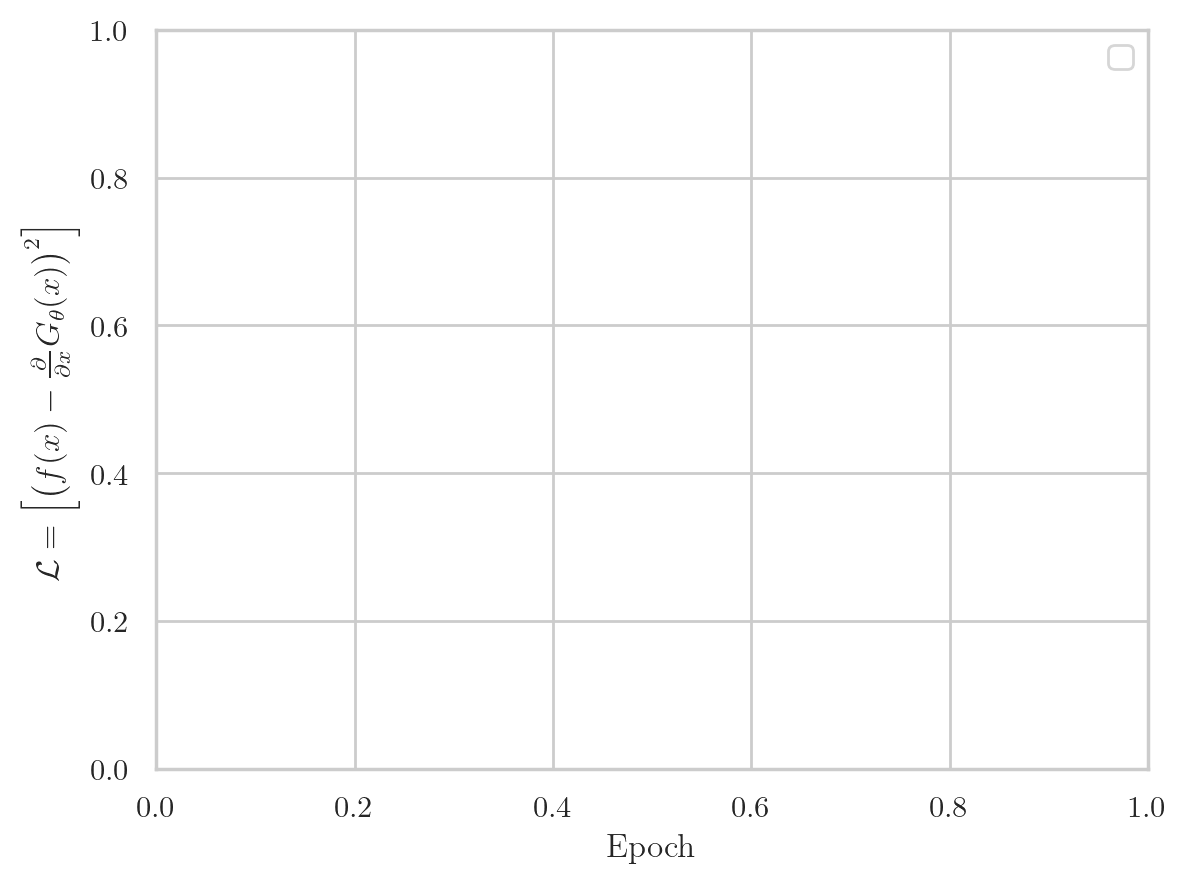

In [38]:
# lrs = [1e-3, 1e-4, 1e-5, 1e-6]
# loss_dict = {}  
# epochs = 1000
# for lr in lrs:
#     losses = train_step(epochs, lr)
#     loss_dict[lr] = losses
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# for lr, losses in loss_dict.items():
#     plt.plot(losses, label=f"lr={lr}")
# plt.legend()
# plt.show()
# plt.xlabel('Epoch')
# plt.ylabel(r"$\mathcal{L} = \left[ \left( f(x) - \frac{\partial}{\partial x} G_\theta(x) \right)^2 \right]$")

# # Show the plot
# plt.show()
# lrs = [1e-3, 1e-4, 1e-5, 1e-6]

loss_dict = {}  
cv_fns = {}
cv_integrals = {}
# epochs = [1000, 2000, 5000, 10000]

# for epoch in epochs:
#     losses = train_step(epoch, lr=1e-4)
#     loss_dict[epoch] = losses
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# for lr, losses in loss_dict.items():
#     plt.plot(losses, label=f"lr={lr}")
# plt.legend()
# plt.show()
# plt.xlabel('Epoch')
# plt.ylabel(r"$\mathcal{L} = \left[ \left( f(x) - \frac{\partial}{\partial x} G_\theta(x) \right)^2 \right]$")

# # Show the plot
# plt.show()

sds = [10, 50,100, 500, 1000,2000]
# for i in sds:
#     losses,cv_fn,cv_integral = train_step(epochs=1000, lr=1e-4, samp_den=i)
#     loss_dict[i] = losses
#     cv_integrals[i] = cv_integral
#     cv_fns[i] = cv_fn
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure( dpi=200)
for lr, losses in loss_dict.items():
    plt.loglog(losses, label=f"samp_den={lr}")
plt.legend()
# plt.show()
plt.xlabel('Epoch')
plt.ylabel(r"$\mathcal{L} = \left[ \left( f(x) - \frac{\partial}{\partial x} G_\theta(x) \right)^2 \right]$")

# Show the plot
plt.show()

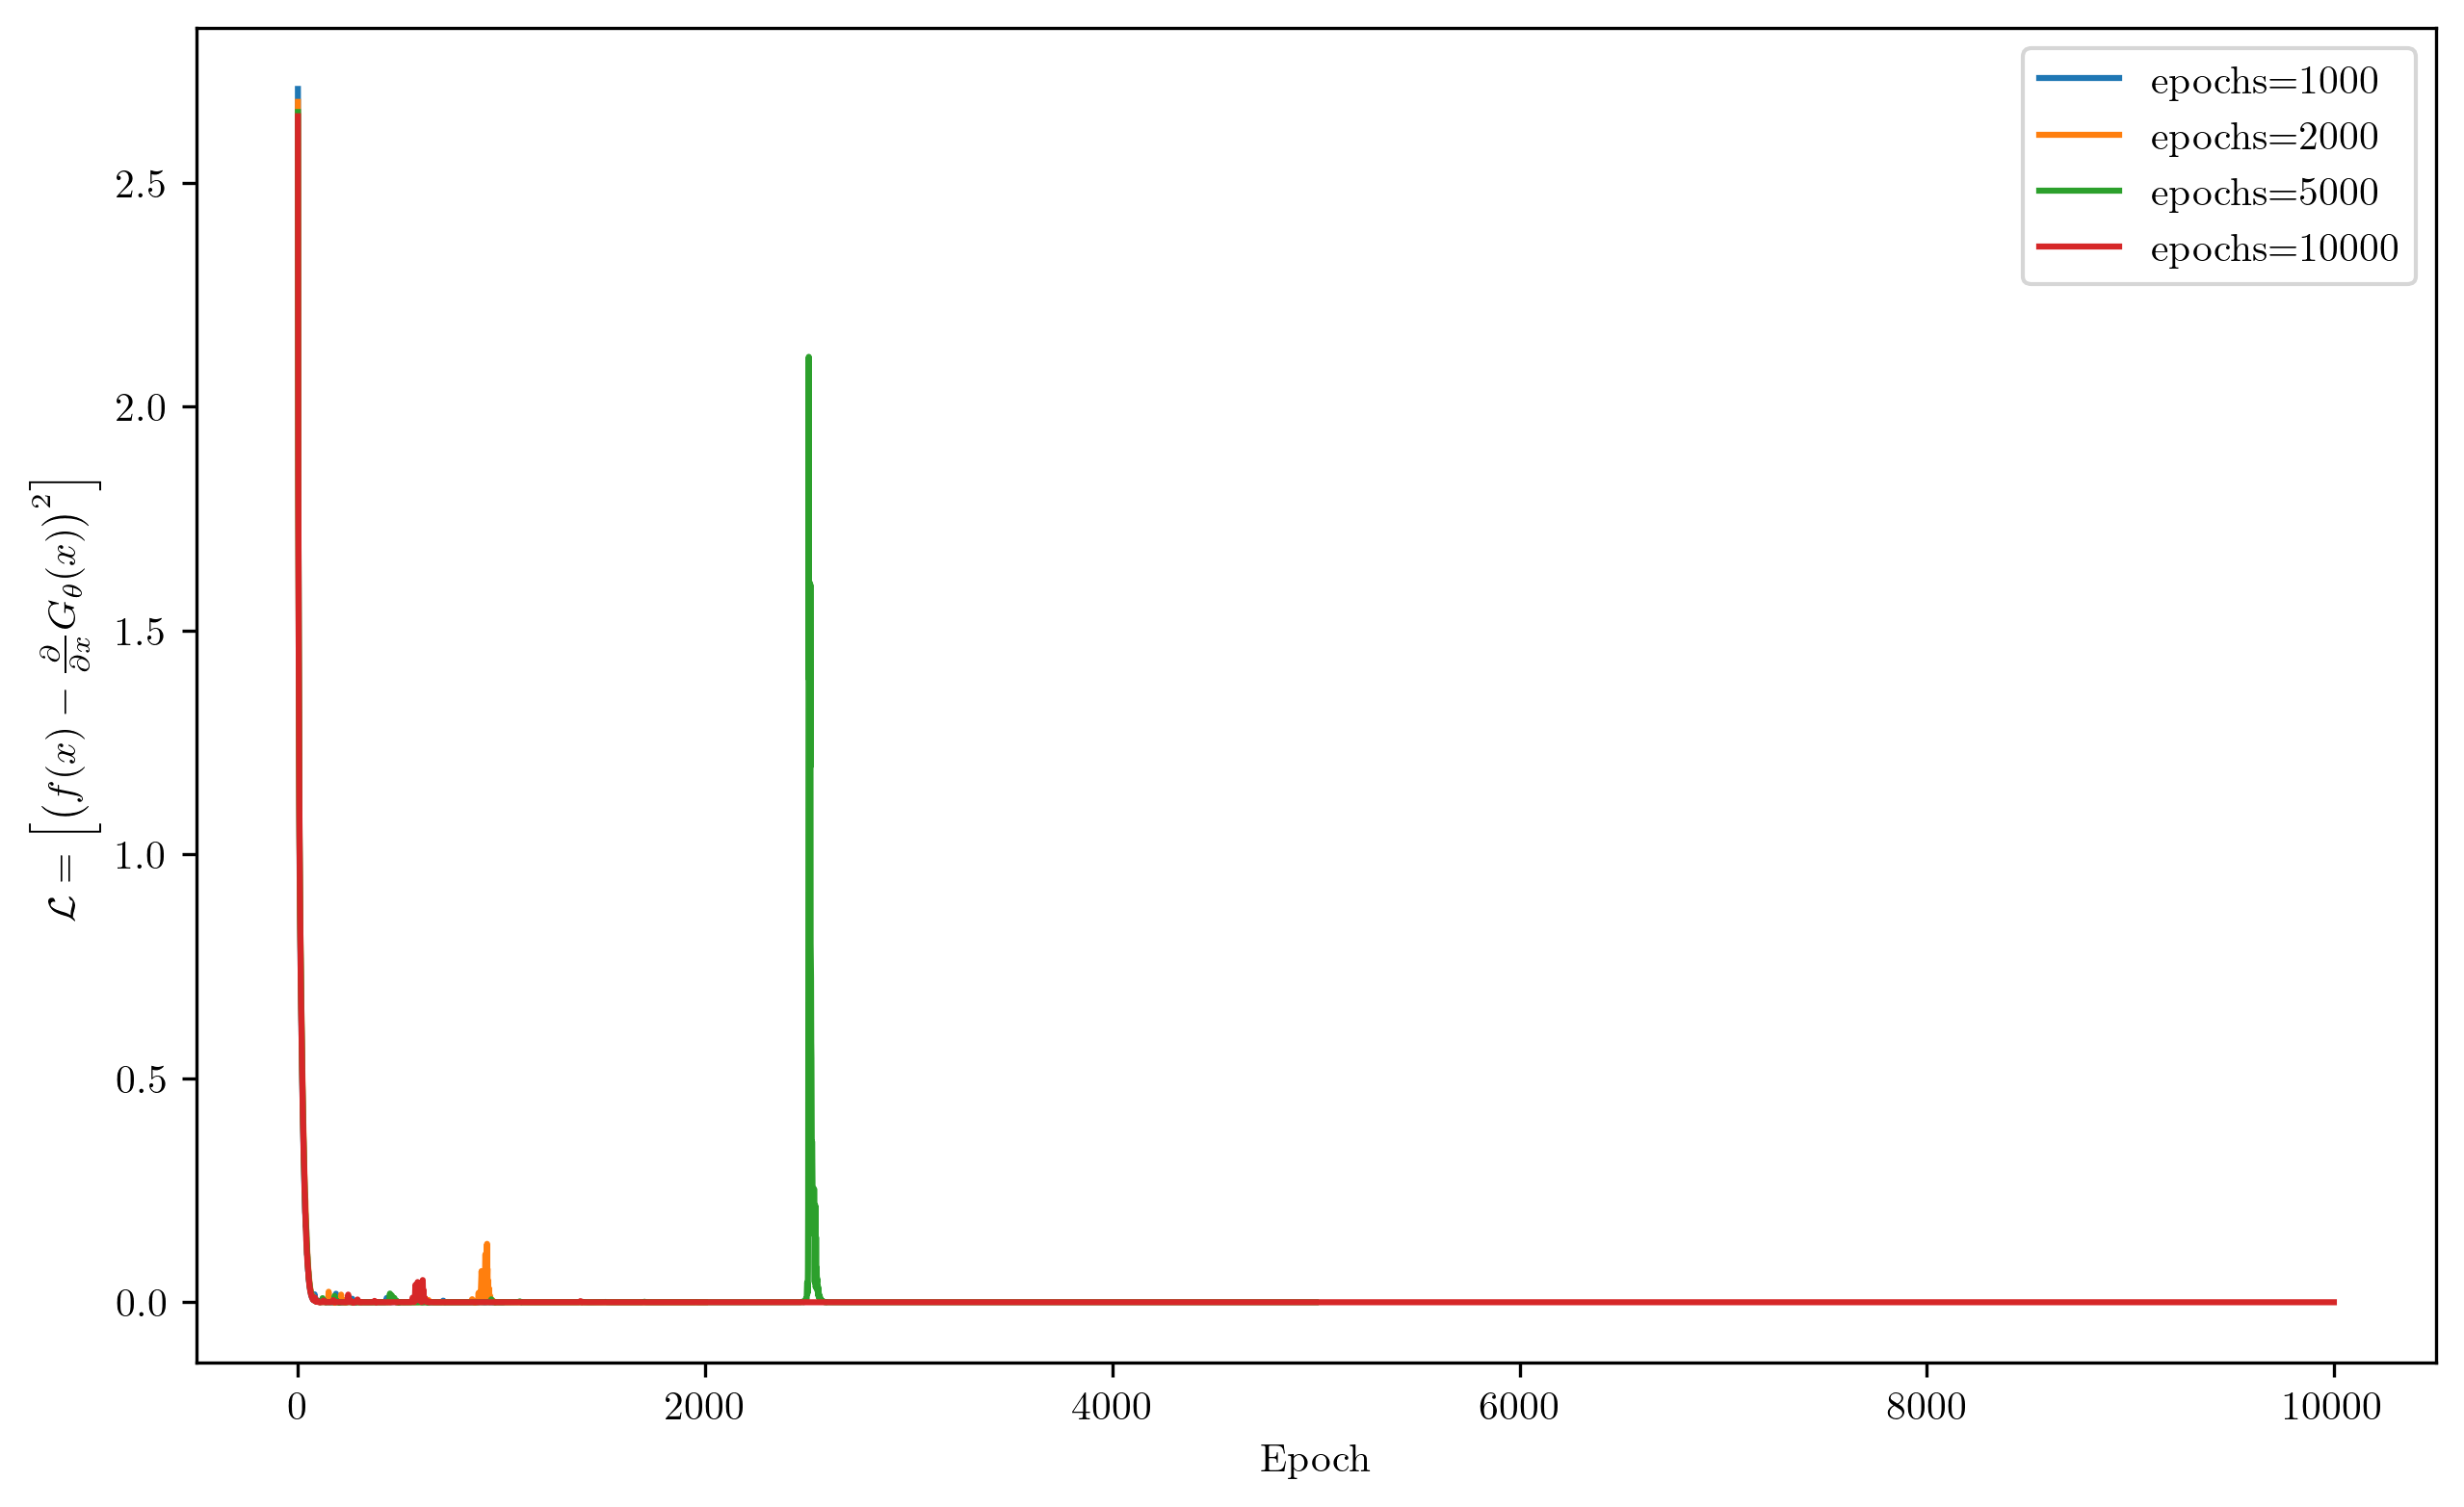

In [20]:
# lrs = [1e-4, 2e-4, 5e-4, 6e-4]
# lrs = [1e-3, 1e-4, 1e-5, 1e-6]

# loss_dict = {}  
# epochs = 1000
# for lr in lrs:
#     losses = train_step(epochs, lr)
#     loss_dict[lr] = losses
epochs = [1000, 2000, 5000, 10000]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(10, 6), dpi=300)
for lr, losses in loss_dict.items():
    plt.plot(losses, label=f"epochs={lr}")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel(r"$\mathcal{L} = \left[ \left( f(x) - \frac{\partial}{\partial x} G_\theta(x) \right)^2 \right]$")
plt.show()
# Show the plot


In [39]:
loss_dict

{}

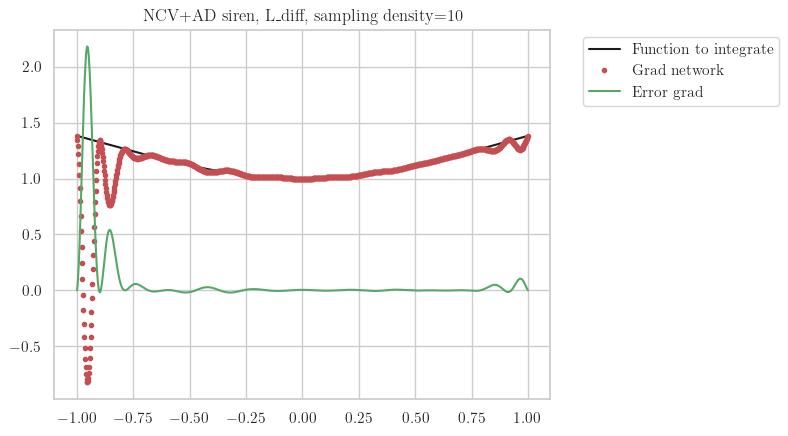

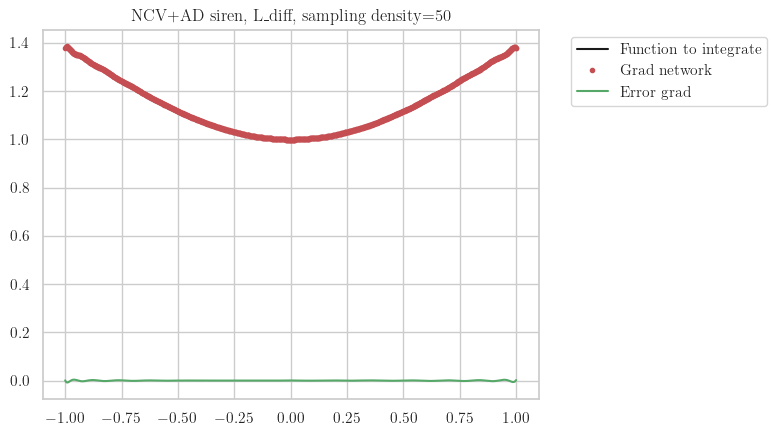

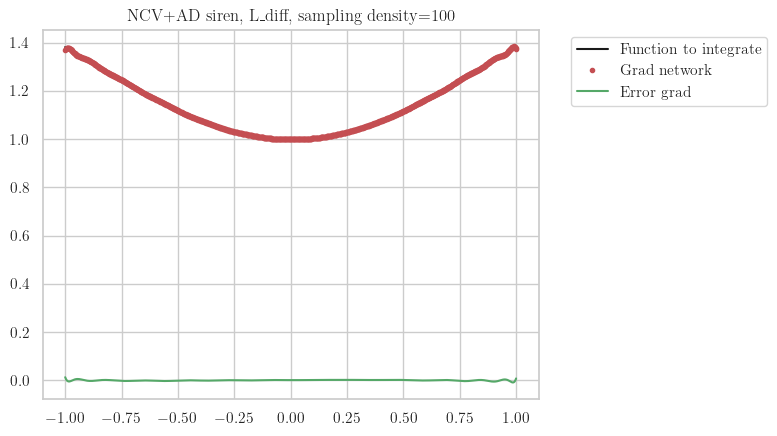

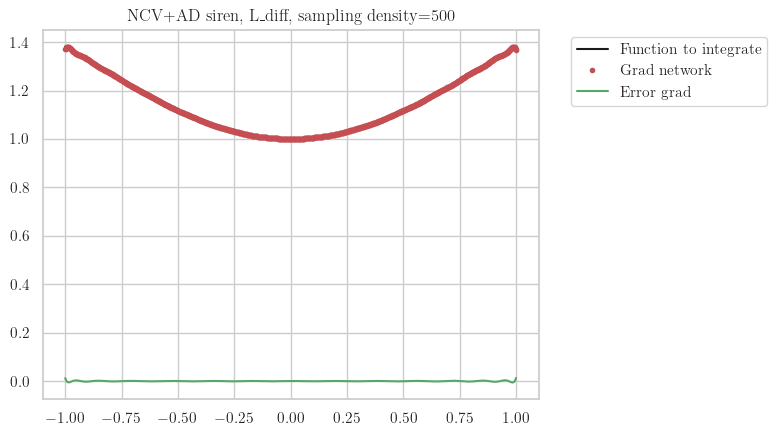

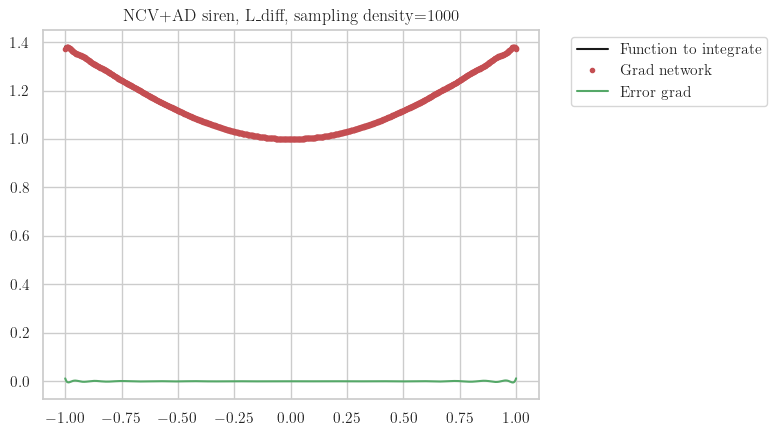

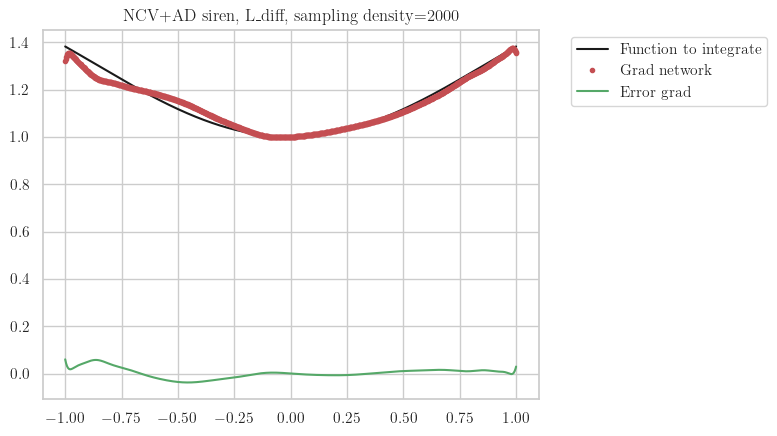

In [36]:
def plot_cv_results(cv_fns, cv_integrals, func_to_fit, L, U, device):
    for samp_den, cv_fn in cv_fns.items():
        cv_integral = cv_integrals[samp_den]
        
        x_coords = torch.linspace(L, U, 1000)[:, None].to(device)
        grad_vals = func_to_fit(x_coords).cpu()
        fitted_grad_vals = cv_fn.compute_graph_fast2({'x_coords': x_coords, 'params': None}).cpu()
        integral_vals = cv_integral.compute_graph_fast2({'x_coords': x_coords, 'params': None}).cpu()

        x_coords = x_coords.cpu()
        
        plt.figure()
        plt.plot(x_coords, grad_vals, '-k', label='Function to integrate')
        plt.plot(x_coords, fitted_grad_vals.detach(), '.r', label='Grad network')
        plt.plot(x_coords, grad_vals - fitted_grad_vals.detach(), '-g', label='Error grad')
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.title(f'NCV+AD siren, L_diff, sampling density={samp_den}')
        plt.show()

# Call the function
plot_cv_results(cv_fns, cv_integrals, func_to_fit, L, U, device)


Text(0, 0.5, '$\\mathcal{L} = \\left[ \\left( f(x) - \\frac{\\partial}{\\partial x} G_\\theta(x) \\right)^2 \\right]$')

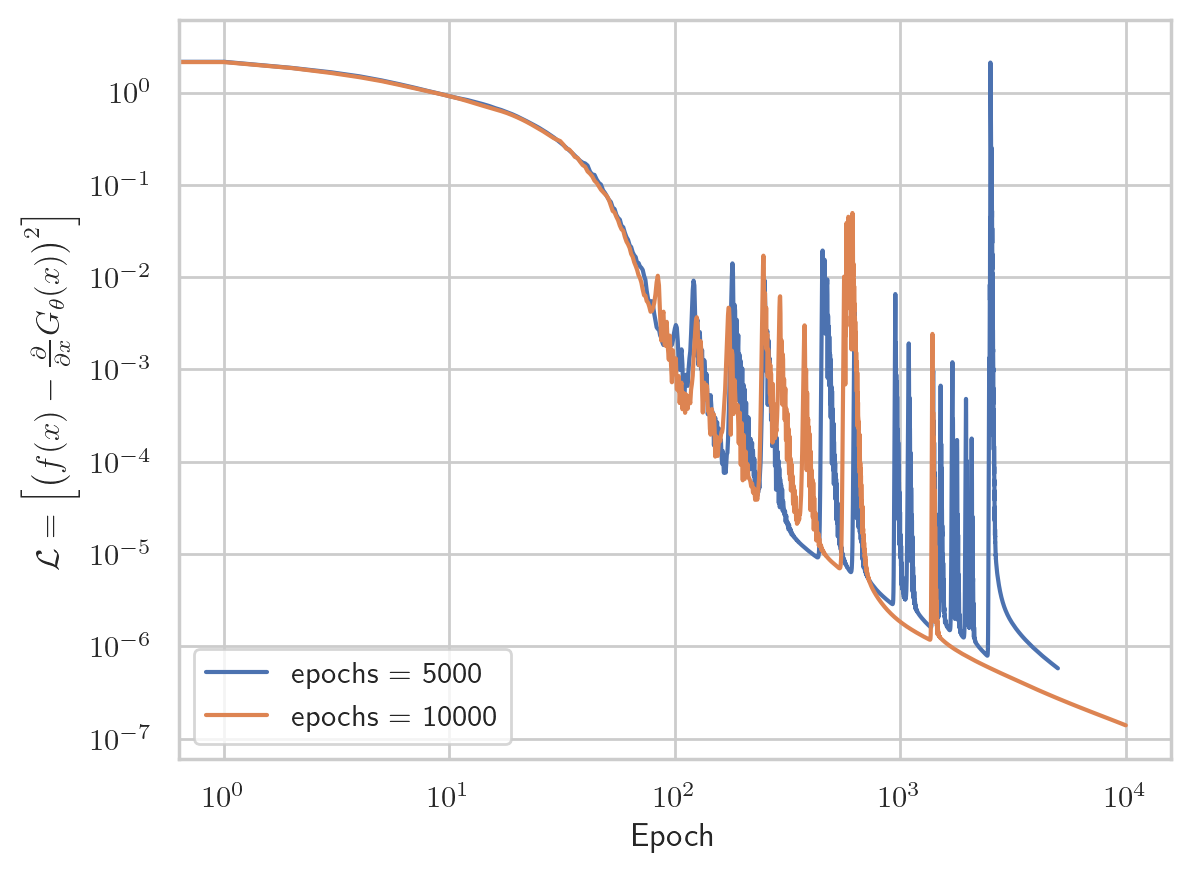

In [30]:
import seaborn as sns
# Seaborn styling
plt.figure( dpi=200)
sns.set_theme(style="whitegrid")
# plt.loglog(loss_dict[1000], label='epochs = 1000')
# plt.loglog(loss_dict[2000], label='epochs = 2000')
plt.loglog(loss_dict[5000], label='epochs = 5000')
plt.loglog(loss_dict[10000], label='epochs = 10000')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel(r"$\mathcal{L} = \left[ \left( f(x) - \frac{\partial}{\partial x} G_\theta(x) \right)^2 \right]$")


Text(0.5, 1.0, 'Loss vs Epoch for SIREN')

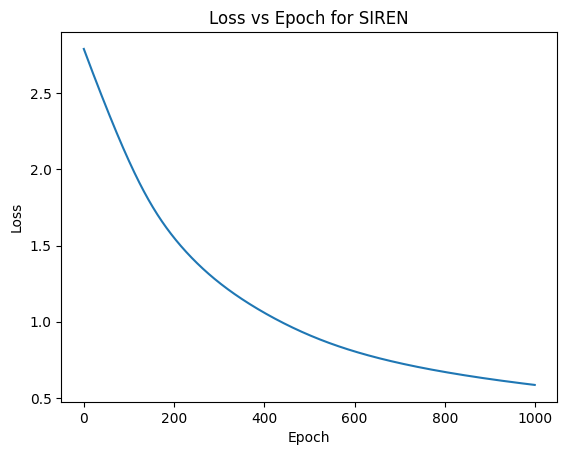

In [18]:
plt.plot(np.arange(0,epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for SIREN')

grad network, integral network

- grad network is trained to approximate the signal/integrand
- integral network is assembled (not trained) from the weights of the trained grad network and is able to approximate the integral of  the signal

Text(0.5, 1.0, 'NCV+AD siren, L_diff, complete sampling')

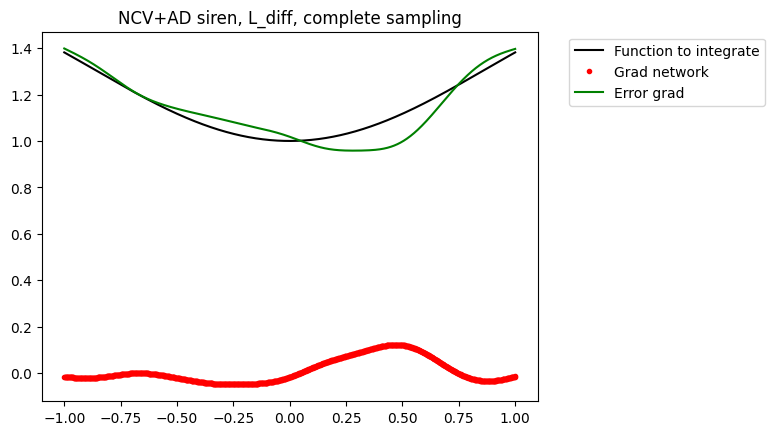

In [19]:
x_coords = torch.linspace(L,U,1000)[:,None].to(device)
grad_vals = func_to_fit(x_coords).cpu()
fitted_grad_vals = cv_fn.compute_graph_fast2({'x_coords': x_coords,
                                                       'params': None}).cpu()
integral_vals = cv_integral.compute_graph_fast2({'x_coords': x_coords,
                                                        'params': None}).cpu()

x_coords = x_coords.cpu()
plt.plot(x_coords,grad_vals,'-k', label='Function to integrate')
plt.plot(x_coords,fitted_grad_vals.detach(),'.r', label='Grad network')
plt.plot(x_coords, grad_vals-fitted_grad_vals.detach(),'-g', label='Error grad')
# #remove outliers
# fitted_grad_vals[abs(fitted_grad_vals)>20]=0
# plt.plot(x_coords,fitted_grad_vals.detach(),'.r', label='Grad network')

# plt.plot(x_coords,integral_vals.detach(),'-b', label='Integral network')
# plt.plot(x_coords,grad_vals-fitted_grad_vals.detach(),'-g', label='Error grad')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('NCV+AD siren, L_diff, complete sampling')


In [ ]:
integralnet_output = net(bounds_tensor).data
g_integral =  (integralnet_output[1]- integralnet_output[0]).detach().cpu() # Analytical integral of g(x) over [0, pi]

# Integration domain and sample count
domain = (L,U)
# n_samples = 10000
sample_sizes = [100, 1000, 10000, 100000]

display_integration_results(func_to_fit, domain, cv_fn, g_integral, sample_sizes, device)

# Perform the integration
# result = cv_monte_carlo_integration(func_to_fit, cv_integral, g_integral, domain, n_samples,device=device)
# print(f"Estimated integral of f(x): {result}")


+-------------+-------------------------------------+
| Sample Size | Integration Result (mean ± std.dev) |
+-------------+-------------------------------------+
|     100     |           2.2761 ± 0.0276           |
|     1000    |           2.2823 ± 0.0086           |
|    10000    |           2.2883 ± 0.0028           |
|    100000   |           2.2863 ± 0.0009           |
|  Scipy Quad |           2.2853 ± 0.0000           |
+-------------+-------------------------------------+


In [21]:
import numpy as np
from prettytable import PrettyTable
from scipy.integrate import quad

def monte_carlo_integration_withstd(func, a, b, num_samples):
    samples = np.random.uniform(a, b, num_samples)
    func_values = func(samples)
    average_value = np.mean(func_values)
    integral_estimate = (b - a) * average_value
    return integral_estimate, np.std(func_values) * (b - a) / np.sqrt(num_samples)

def f(x):
    return integral_xcosx_fn_numpy(x)

def display_integration_results_normal(func, a, b, sample_sizes):
    # Numerical quadrature integration
    quad_result, _ = quad(func, a, b)

    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Sample Size", "Integration Result without NCV(mean ± std.dev)"]

    # Compute and add results for different sample sizes
    for num_samples in sample_sizes:
        mc_mean, mc_std = monte_carlo_integration_withstd(func, a, b, num_samples)
        table.add_row([num_samples, f"{mc_mean:.4f} ± {mc_std:.4f}"])

    # Add the quadrature result to the table
    table.add_row(["Scipy Quad", f"{quad_result:.4f} ± 0.0000"])

    # Print the table
    print(table)

# Example usage
a = L
b = U
sample_sizes = [100, 1000, 10000, 100000]

display_integration_results_normal(f, a, b, sample_sizes)

+-------------+------------------------------------------------+
| Sample Size | Integration Result without NCV(mean ± std.dev) |
+-------------+------------------------------------------------+
|     100     |                2.3234 ± 0.0248                 |
|     1000    |                2.2900 ± 0.0076                 |
|    10000    |                2.2871 ± 0.0024                 |
|    100000   |                2.2853 ± 0.0008                 |
|  Scipy Quad |                2.2853 ± 0.0000                 |
+-------------+------------------------------------------------+


In [22]:
with torch.no_grad():
    integralnet_output = net(bounds_tensor).data
with torch.no_grad():
    int2 = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor ,'params': None})
with torch.no_grad():
    gradnet_output = cv_fn.compute_graph_fast2({'x_coords': bounds_tensor ,'params': None})
print(integralnet_output)
print(int2)
print(gradnet_output)

tensor([[-0.1379],
        [-0.1208]], device='mps:0')
tensor([[-0.1379],
        [-0.1208]], device='mps:0')
tensor([[-0.0169],
        [-0.0150]], device='mps:0')
